# Set-up

In [ ]:
!pip install great_tables   # for styling tables

In [2]:
import pandas as pd
import numpy as np
import os   # for looping through local directory

import plotly.express as px
import matplotlib.pyplot as plt   # for creating plots with axes
import matplotlib.image as mpimg  # for adding images to plots
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import great_tables as gt
from great_tables import GT, style, loc

In [3]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

Data from [Pro Football Reference 2024 NFL Fantasy Ranks](https://www.pro-football-reference.com/years/2024/fantasy.htm)

In [4]:
# load in fantasy df from Google Drive
fantasy_data = pd.read_csv("/content/drive/MyDrive/Fantasy Football/Data/Pro football reference/2024/pfr_fantasy_data_2024.csv")

In [5]:
# filter out RBs
fantasy_rb_data = fantasy_data[fantasy_data["FantPos"] == "RB"]

# keep relevant columns
fantasy_rb_data = fantasy_rb_data[["Player", "Rush_Att", "Tgt", "FDPt"]]

# convert column values to be integers (easier to see)
fantasy_rb_data[["Rush_Att", "Tgt"]] = fantasy_rb_data[["Rush_Att", "Tgt"]].astype(int)

# create new "Opp" (opportunities) column by adding values from "Rush_Att" and "Tgt" columns
fantasy_rb_data["Opp"] = fantasy_rb_data["Rush_Att"] + fantasy_rb_data["Tgt"]

# create new "Adj_Opp" (adjusted opportunities) where targets are worth 1.5 times more than a rush attempt
fantasy_rb_data["Adj_Opp"] = fantasy_rb_data["Rush_Att"] + fantasy_rb_data["Tgt"]*1.5

# filter df to only include RBs with more than 100 opportunities
fantasy_rb_data = fantasy_rb_data[fantasy_rb_data["Opp"] >= 100]

# display first 10 rows of df
fantasy_rb_data.head(10)

,Player,Rush_Att,Tgt,FDPt,Opp,Adj_Opp
0,Saquon Barkley,345,43,338.8,388,409.5
1,Derrick Henry,325,22,326.9,347,358.0
2,Jahmyr Gibbs,250,63,336.9,313,344.5
5,Bijan Robinson,304,72,311.2,376,412.0
6,Josh Jacobs,301,43,275.1,344,365.5
9,Kyren Williams,316,40,255.1,356,376.0
10,James Cook,207,38,250.7,245,264.0
13,Jonathan Taylor,303,31,235.7,334,349.5
16,DeVon Achane,203,87,260.9,290,333.5
20,James Conner,236,55,230.3,291,318.5


Data from [Pro Football Reference 2024 NFL Redzone Rushing Statistics](https://www.pro-football-reference.com/years/2024/redzone-rushing.htm)

In [6]:
rz_rushing_data = pd.read_csv("/content/drive/MyDrive/Fantasy Football/Data/Pro football reference/2024/pfr_rz_rushing_data_2024.csv")

In [7]:
# only include relevant columns
rz_rushing_data = rz_rushing_data[["Player", "Att_ins_5"]]

# replace specific names to match other df
rz_rushing_data["Player"] = rz_rushing_data["Player"].replace({"Tyrone Tracy": "Tyrone Tracy Jr.", "Brian Robinson": "Brian Robinson Jr.", "Kenneth Walker": "Kenneth Walker III"})

# display top 10 rows
rz_rushing_data.head(10)

,Player,Att_ins_5
0,Kyren Williams,19
1,Bijan Robinson,14
2,Jonathan Taylor,15
3,Josh Jacobs,19
4,Joe Mixon,12
5,Saquon Barkley,13
6,Derrick Henry,18
7,Jahmyr Gibbs,15
8,Najee Harris,7
9,Jalen Hurts,18


In [8]:
# create new df by merging fantasy data and redzone rushing data (only includes the top 40 players)
rb_volume_data = pd.merge(fantasy_rb_data, rz_rushing_data, on="Player", how="left")
rb_volume_data = rb_volume_data[["Player", "Opp", "Adj_Opp", "Att_ins_5", "FDPt"]]
rb_volume_data["Rank"] = rb_volume_data["FDPt"].rank(ascending=False, method="min").astype(int)
rb_volume_data = rb_volume_data.sort_values("FDPt", ascending=False).head(40)

# creating new "Tier" column based on fantasy points scored last season (intervals of 10)
tiers = [
    rb_volume_data["Rank"] <= 10,
    (rb_volume_data["Rank"] > 10) & (rb_volume_data["Rank"] <= 20),
    (rb_volume_data["Rank"] > 20) & (rb_volume_data["Rank"] <= 30),
    rb_volume_data["Rank"] > 30
]
choices = [1, 2, 3, 4]

rb_volume_data["Tier"] = np.select(tiers, choices)
rb_volume_data["Tier"] = rb_volume_data["Tier"].astype("category")

# adding image column that contains headshot paths (for plotting with plt)
img_path = "/content/drive/MyDrive/Substack/NFL images/RB"
rb_volume_data["Image"] = rb_volume_data["Player"].apply(lambda name: os.path.join(img_path, f"{name}.png"))  # individual image paths created by concatenating path with player name
rb_volume_data["Image"] = rb_volume_data["Image"].apply(lambda path: path if os.path.exists(path) else None)  # if path not found (image not in directory), label value as None

# display top 15
rb_volume_data.head(15)

,Player,Opp,Adj_Opp,Att_ins_5,FDPt,Rank,Tier,Image
0,Saquon Barkley,388,409.5,13,338.8,1,1,/content/drive/MyDrive/Substack/NFL images/RB/...
2,Jahmyr Gibbs,313,344.5,15,336.9,2,1,/content/drive/MyDrive/Substack/NFL images/RB/...
1,Derrick Henry,347,358.0,18,326.9,3,1,/content/drive/MyDrive/Substack/NFL images/RB/...
3,Bijan Robinson,376,412.0,14,311.2,4,1,/content/drive/MyDrive/Substack/NFL images/RB/...
4,Josh Jacobs,344,365.5,19,275.1,5,1,/content/drive/MyDrive/Substack/NFL images/RB/...
8,DeVon Achane,290,333.5,12,260.9,6,1,/content/drive/MyDrive/Substack/NFL images/RB/...
5,Kyren Williams,356,376.0,19,255.1,7,1,/content/drive/MyDrive/Substack/NFL images/RB/...
6,James Cook,245,264.0,13,250.7,8,1,/content/drive/MyDrive/Substack/NFL images/RB/...
7,Jonathan Taylor,334,349.5,15,235.7,9,1,/content/drive/MyDrive/Substack/NFL images/RB/...
14,Alvin Kamara,317,361.5,7,231.3,10,1,/content/drive/MyDrive/Substack/NFL images/RB/...


# Creating an interactive scatterplot (NOT USED)

In [9]:
hover_cols = {"Player": True,
              "Rank": True,
              "Opp": False,
              "Adj_Opp": False,
              "Att_ins_5": False,
              "FDPt": False,
              "Tier": False
              }

fig = px.scatter(
    data_frame=rb_volume_data,
    x="Att_ins_5",
    y="Adj_Opp",
    size="FDPt",
    color="Tier",
    hover_data=hover_cols,
    # trendline="ols"
)

# # Add horizontal line at y=340
# fig.add_hline(y=340, line_dash="dash", line_color="black")

# # Add vertical line at x=13
# fig.add_vline(x=13, line_dash="dash", line_color="black")

fig.show()

# Creating Cool Scatterplots

## Simple Scatterplot

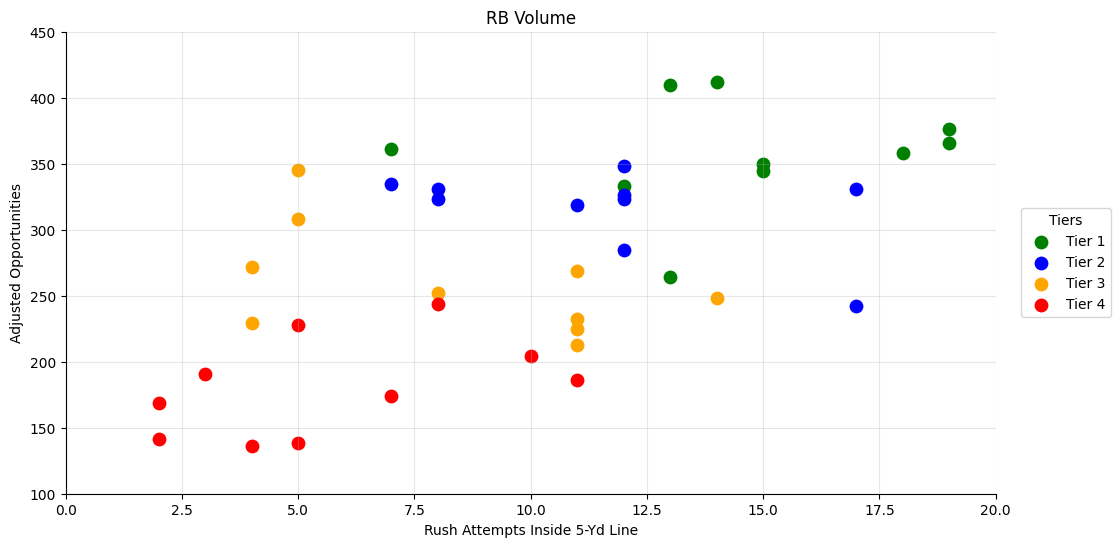

In [10]:
# colors for each tier
tier_colors = {
    1: "green",
    2: "blue",
    3: "orange",
    4: "red"
}

# scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# loop through rows
for _, row in rb_volume_data.iterrows():
    color = tier_colors.get(row["Tier"], "gray")
    ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")

# handle legend (avoid duplicates)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Tiers", loc="center left", bbox_to_anchor=(1.02, 0.5))


# axes formatting
ax.set_xlim(0, 20)
ax.set_ylim(100, 450)
ax.set_xlabel("Rush Attempts Inside 5-Yd Line")
ax.set_ylabel("Adjusted Opportunities")
ax.set_title("RB Volume")
ax.grid(True, alpha=0.3, zorder=0)

# remove outer border
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig('/content/drive/MyDrive/Substack/8.29/RB_Volume_Tiers.png', dpi=300)

plt.show()

## Scatterplot with Tier 1 RBs Visualized

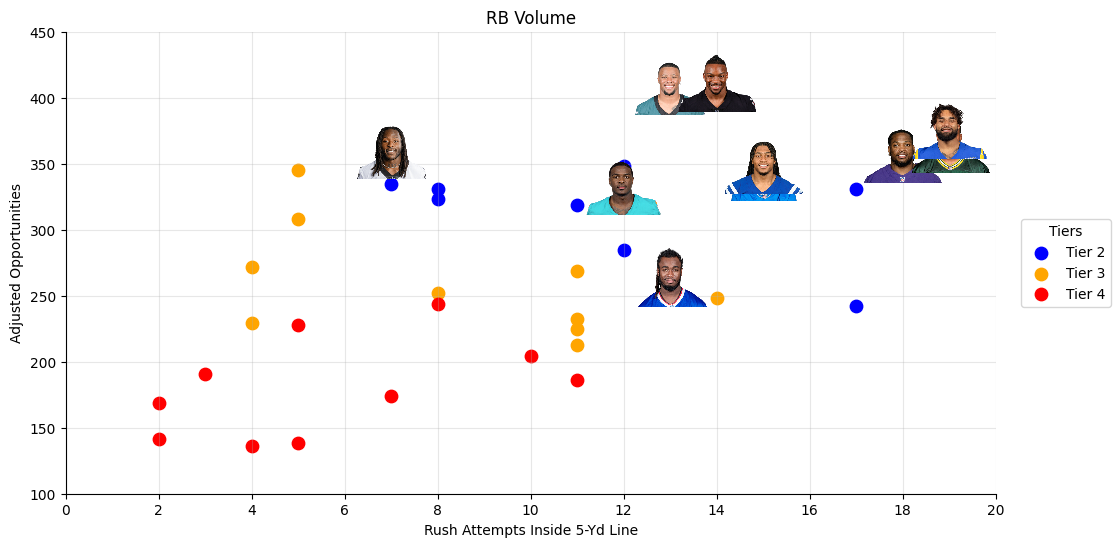

In [11]:
# scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# loop through rows
for _, row in rb_volume_data.iterrows():
    color = tier_colors.get(row["Tier"], "gray")

    if row["Tier"] == 1 and row["Image"] is not None:
        try:
            # plot image for Tier 1
            img = mpimg.imread(row["Image"])
            ab = AnnotationBbox(
                OffsetImage(img, zoom=0.17),
                (row["Att_ins_5"], row["Adj_Opp"]),
                frameon=False
            )
            ax.add_artist(ab)
        except FileNotFoundError:
            # fallback to colored dot if image is missing
            ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")
    else:
        # plot regular colored dot for non-Tier 1 players
        ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")

# legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Tiers", loc="center left", bbox_to_anchor=(1.02, 0.5))

# axes formatting
ax.set_xlim(0, 20)
ax.set_ylim(100, 450)
ax.set_xticks(range(0, 21, 2))
ax.set_xlabel("Rush Attempts Inside 5-Yd Line")
ax.set_ylabel("Adjusted Opportunities")
ax.set_title("RB Volume")
ax.grid(True, alpha=0.3, zorder=0)

# remove outer border
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig('/content/drive/MyDrive/Substack/8.29/RB_Volume_Tier_1.png', dpi=300)

plt.show()

## Risers Scatterplot

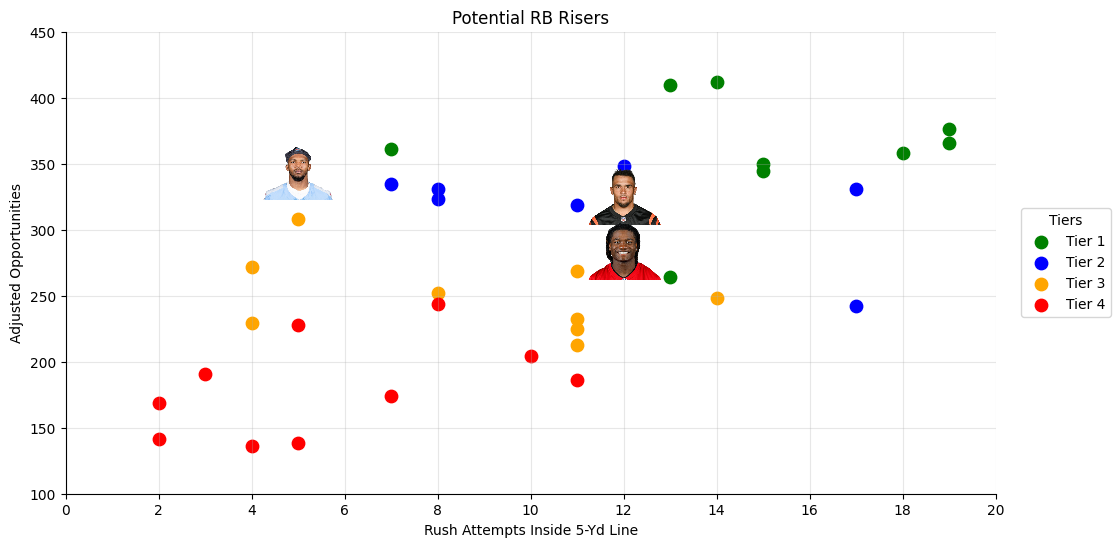

In [12]:
risers = ["Bucky Irving", "Chase Brown", "Tony Pollard"]

fig, ax = plt.subplots(figsize=(12, 6))

for _, row in rb_volume_data.iterrows():
    color = tier_colors.get(row["Tier"], "gray")

    if row["Player"] in risers and row["Image"] is not None:
        try:
            # plot image for risers
            img = mpimg.imread(row["Image"])
            ab = AnnotationBbox(
                OffsetImage(img, zoom=0.17),
                (row["Att_ins_5"], row["Adj_Opp"]),
                frameon=False
            )
            ax.add_artist(ab)
        except FileNotFoundError:
            # fallback to colored dot if image is missing
            ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")
    else:
        # plot regular colored dot for non-riser players
        ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Tiers", loc="center left", bbox_to_anchor=(1.02, 0.5))

ax.set_xlim(0, 20)
ax.set_ylim(100, 450)
ax.set_xticks(range(0, 21, 2))
ax.set_xlabel("Rush Attempts Inside 5-Yd Line")
ax.set_ylabel("Adjusted Opportunities")
ax.set_title("Potential RB Risers")
ax.grid(True, alpha=0.3, zorder=0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig('/content/drive/MyDrive/Substack/8.29/RB_Volume_Risers.png', dpi=300)

plt.show()

## Fallers Scatterplot

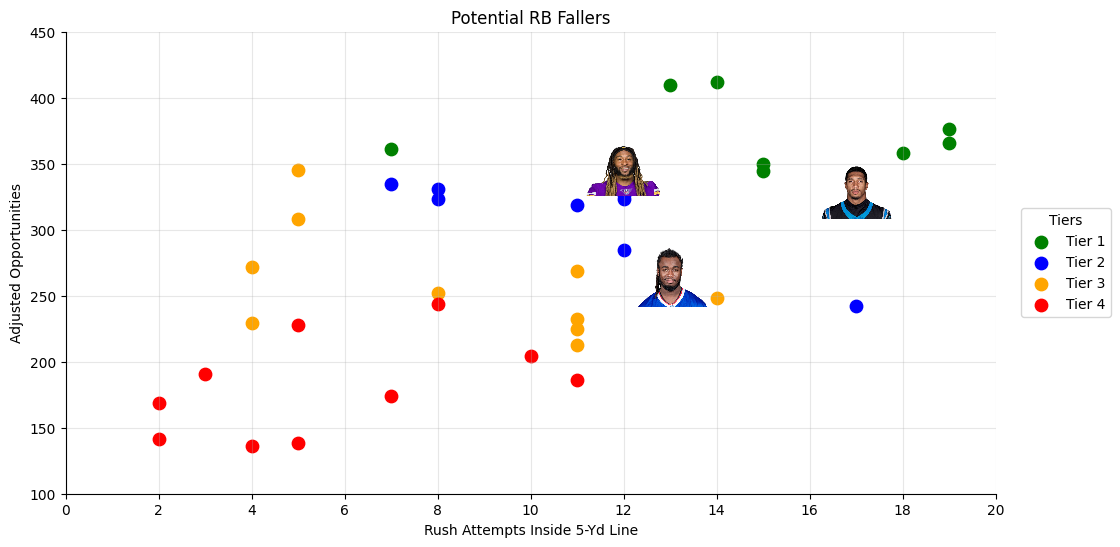

In [13]:
fallers = ["Chuba Hubbard", "James Cook", "Aaron Jones"]

fig, ax = plt.subplots(figsize=(12, 6))

for _, row in rb_volume_data.iterrows():
    color = tier_colors.get(row["Tier"], "gray")

    if row["Player"] in fallers and row["Image"] is not None:
        try:
            # Plot image for fallers
            img = mpimg.imread(row["Image"])
            ab = AnnotationBbox(
                OffsetImage(img, zoom=0.17),
                (row["Att_ins_5"], row["Adj_Opp"]),
                frameon=False
            )
            ax.add_artist(ab)
        except FileNotFoundError:
            # fallback to colored dot if image is missing
            ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")
    else:
        # Plot regular colored dot for non-fallers players
        ax.scatter(row["Att_ins_5"], row["Adj_Opp"], color=color, s=80, label=f"Tier {row['Tier']}")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          title="Tiers", loc="center left", bbox_to_anchor=(1.02, 0.5))

ax.set_xlim(0, 20)
ax.set_ylim(100, 450)
ax.set_xticks(range(0, 21, 2))
ax.set_xlabel("Rush Attempts Inside 5-Yd Line")
ax.set_ylabel("Adjusted Opportunities")
ax.set_title("Potential RB Fallers")
ax.grid(True, alpha=0.3, zorder=0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig('/content/drive/MyDrive/Substack/8.29/RB_Volume_Fallers.png', dpi=300)

plt.show()

# Riser/Faller ADP Comparison

Data from [FantasyPros ADP tracker](https://www.fantasypros.com/nfl/adp/half-point-ppr-overall.php)

In [15]:
# list of risers and fallers
risers_fallers = ["Bucky Irving", "Chase Brown", "Tony Pollard", "Chuba Hubbard", "James Cook", "Aaron Jones"]

# load and clean ADP df
rb_adp = pd.read_csv("/content/drive/MyDrive/Substack/8.29/FP_2025_RB_ADP_Rankings.csv")
rb_adp = rb_adp.drop(columns=["Real-Time (?)", "Overall", "Bye"])
rb_adp["Player"] = rb_adp["Player"].replace({"Aaron Jones Sr.": "Aaron Jones"})
riser_faller_adp = rb_adp[rb_adp["Player"].isin(risers_fallers)].copy()
riser_faller_adp[["RB", "Yahoo", "Sleeper", "RTSports"]] = riser_faller_adp[["RB", "Yahoo", "Sleeper", "RTSports"]] .astype(int)
riser_faller_adp

,RB,Player,Team,Yahoo,Sleeper,RTSports,AVG
9,10,Bucky Irving,TB,10,10,10,10.0
10,11,Chase Brown,CIN,11,12,9,10.7
12,13,James Cook,BUF,13,13,14,13.3
17,18,Chuba Hubbard,CAR,16,18,19,17.7
24,25,Tony Pollard,TEN,22,26,23,23.7
25,26,Aaron Jones,MIN,27,24,26,25.7


In [16]:
# filter player name and last season's finish
riser_faller_ranks = rb_volume_data[rb_volume_data["Player"].isin(risers_fallers)].copy()
riser_faller_ranks = riser_faller_ranks[["Player", "Rank"]]
riser_faller_ranks

,Player,Rank
6,James Cook,8
11,Chase Brown,12
13,Bucky Irving,14
12,Chuba Hubbard,15
15,Aaron Jones,16
21,Tony Pollard,21


In [17]:
# create new df by merging ADP data and last year's finish data
riser_faller_adp_comparison = pd.merge(riser_faller_adp, riser_faller_ranks, on="Player", how="inner")
riser_faller_adp_comparison["Player Name"] = riser_faller_adp_comparison["Player"]

# create new column that calculates expected change in draft finish
riser_faller_adp_comparison["Change"] = riser_faller_adp_comparison["Rank"] - riser_faller_adp_comparison["RB"]
riser_faller_adp_comparison = riser_faller_adp_comparison[["Team", "Player Name", "Player", "Rank", "RB", "Change"]]
riser_faller_adp_comparison

,Team,Player Name,Player,Rank,RB,Change
0,TB,Bucky Irving,Bucky Irving,14,10,4
1,CIN,Chase Brown,Chase Brown,12,11,1
2,BUF,James Cook,James Cook,8,13,-5
3,CAR,Chuba Hubbard,Chuba Hubbard,15,18,-3
4,TEN,Tony Pollard,Tony Pollard,21,25,-4
5,MIN,Aaron Jones,Aaron Jones,16,26,-10


## Riser/Faller Table

Logos from https://www.sportslogos.net/ <br>
Headshots from https://www.espn.com/

[Table formatting reference](https://posit-dev.github.io/great-tables/reference/)

GT(_tbl_data=  Team    Player Name         Player  Rank  RB  Change
0   TB   Bucky Irving   Bucky Irving    14  10       4
1  CIN    Chase Brown    Chase Brown    12  11       1
2  BUF     James Cook     James Cook     8  13      -5
3  CAR  Chuba Hubbard  Chuba Hubbard    15  18      -3
4  TEN   Tony Pollard   Tony Pollard    21  25      -4
5  MIN    Aaron Jones    Aaron Jones    16  26     -10, _body=<great_tables._gt_data.Body object at 0x793997eb7d70>, _boxhead=Boxhead([ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='center', column_width=None), ColInfo(var='Player Name', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Player', type=<ColInfoTypeEnum.default: 1>, column_label='Player', column_align='left', column_width=None), ColInfo(var='Rank', type=<ColInfoTypeEnum.default: 1>, column_label='2024 Finish', column_align='center', column_width=None), ColInfo(var='RB', type=<ColInfoTypeEnum.default: 1>, column_label='2025 ADP', column_align='center', column_width=None), ColInfo(var='Change', type=<ColInfoTypeEnum.default: 1>, column_label='Change', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x793996b1a270>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Risers and Fallers**'), subtitle='Potential RB Risers and Fallers based on change in expected volume', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Change', rows=[0], mask=None), grpname=None, colname='Change', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#44ad88')]), StyleInfo(locname=LocBody(columns='Change', rows=[1], mask=None), grpname=None, colname='Change', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8cc9b5')]), StyleInfo(locname=LocBody(columns='Change', rows=[2], mask=None), grpname=None, colname='Change', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#dabecb')]), StyleInfo(locname=LocBody(columns='Change', rows=[3], mask=None), grpname=None, colname='Change', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#eceff1')]), StyleInfo(locname=LocBody(columns='Change', rows=[4], mask=None), grpname=None, colname='Change', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#e3d7de')]), StyleInfo(locname=LocBody(columns='Change', rows=[5], mask=None), grpname=None, colname='Change', rownum=5, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#ac456b')])], _locale=<great_tables._gt_data.Locale object at 0x793997e8e480>, _formats=[<great_tables._gt_data.FormatInfo object at 0x793997f3c800>, <great_tables._gt_data.FormatInfo object at 0x793996c386e0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, catego
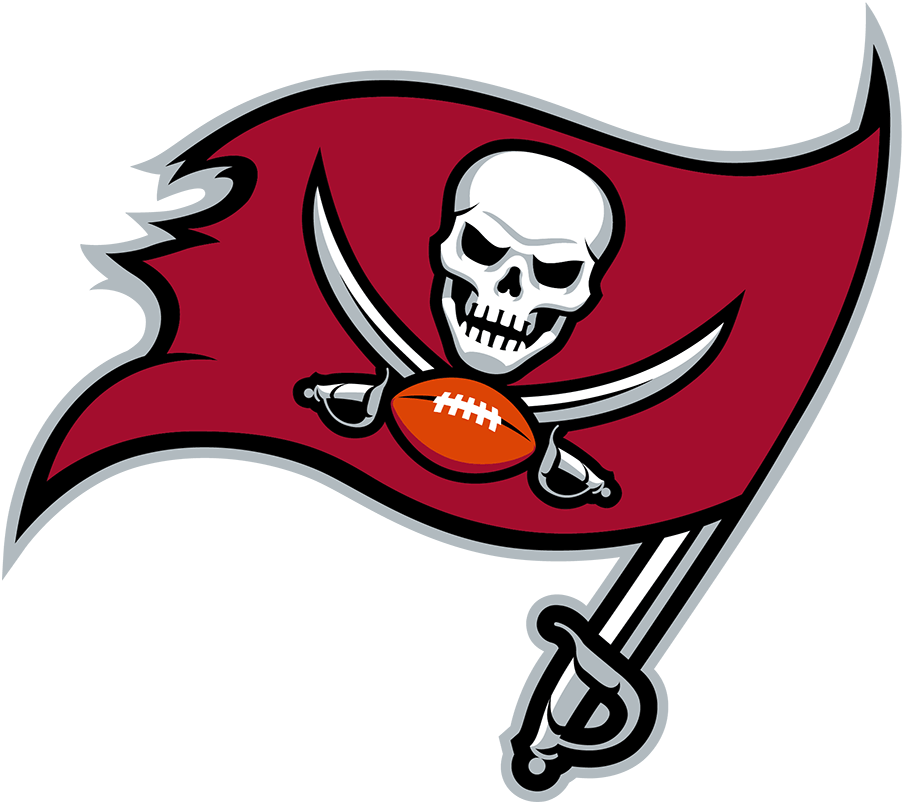
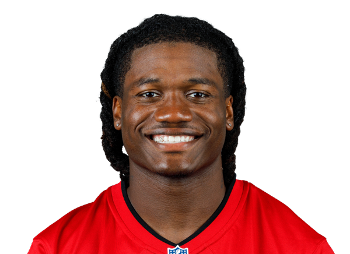
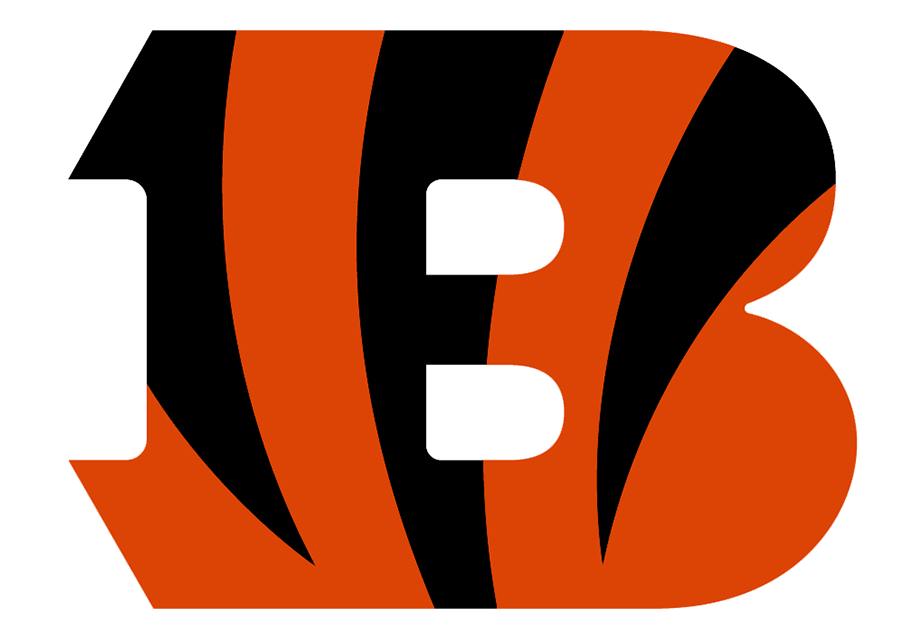
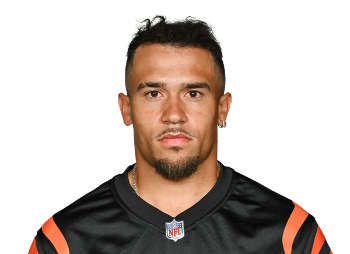
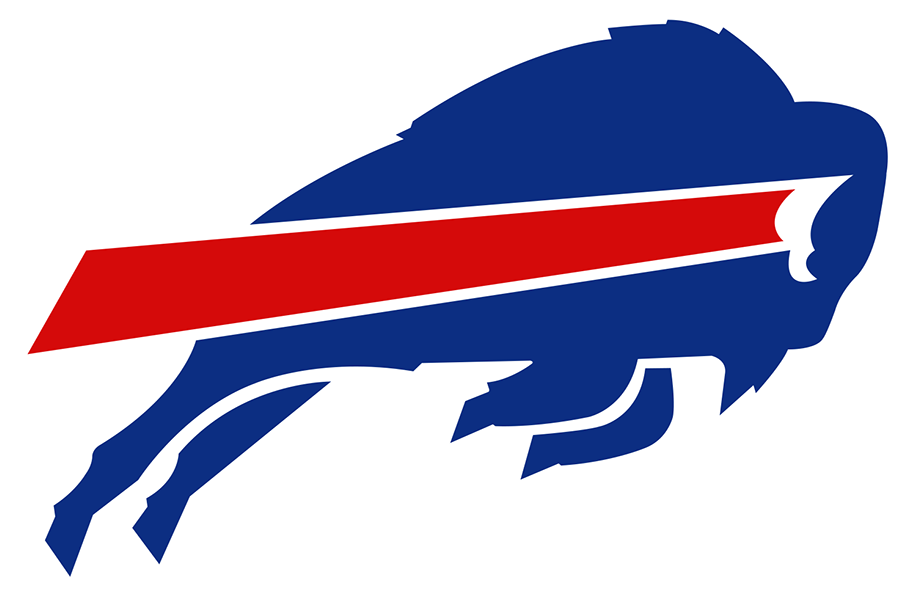
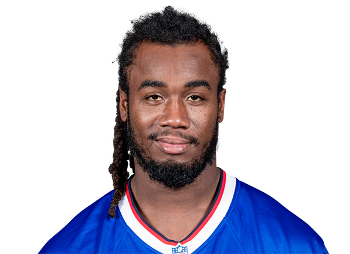
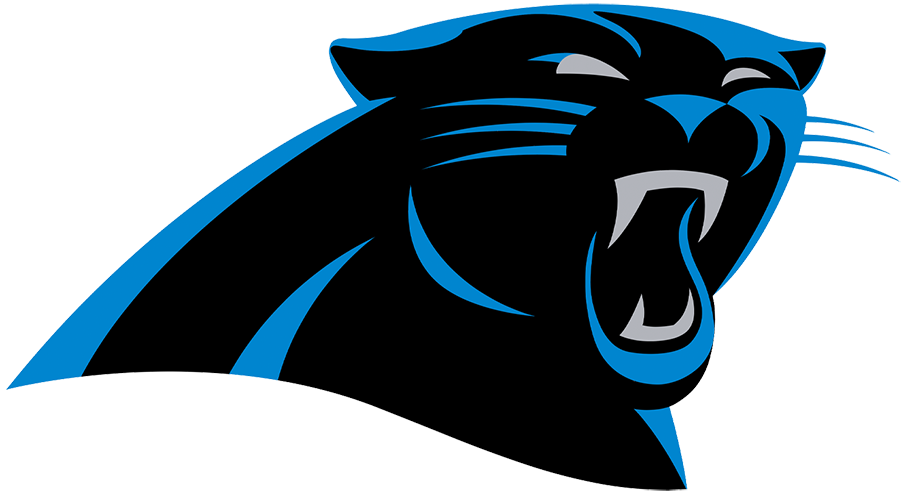
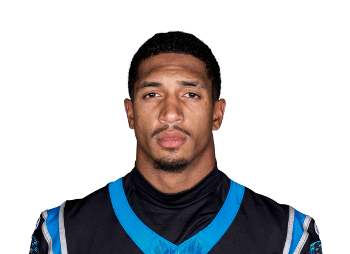
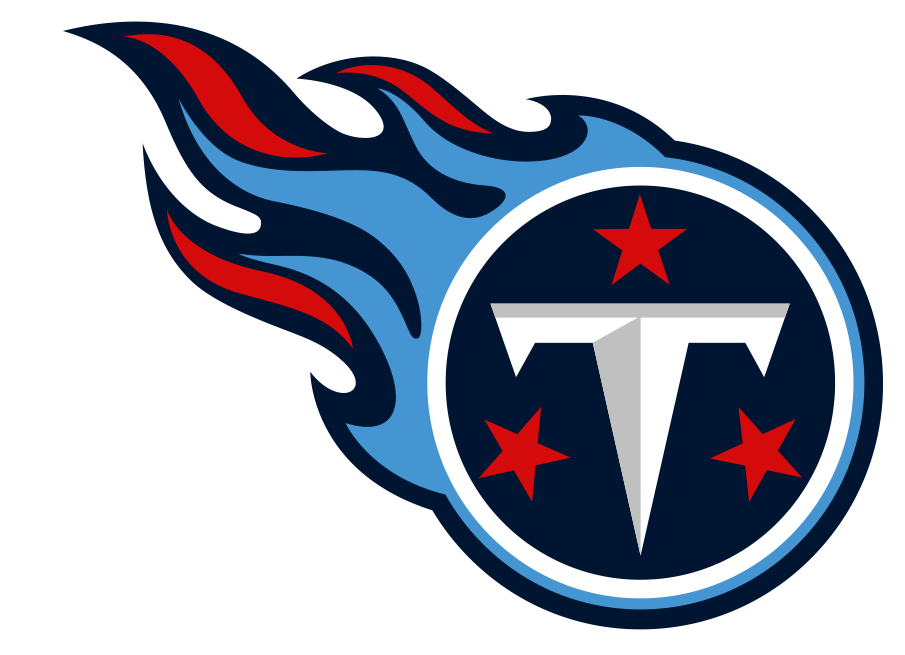
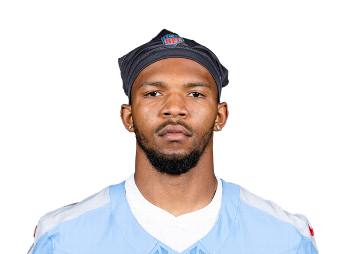
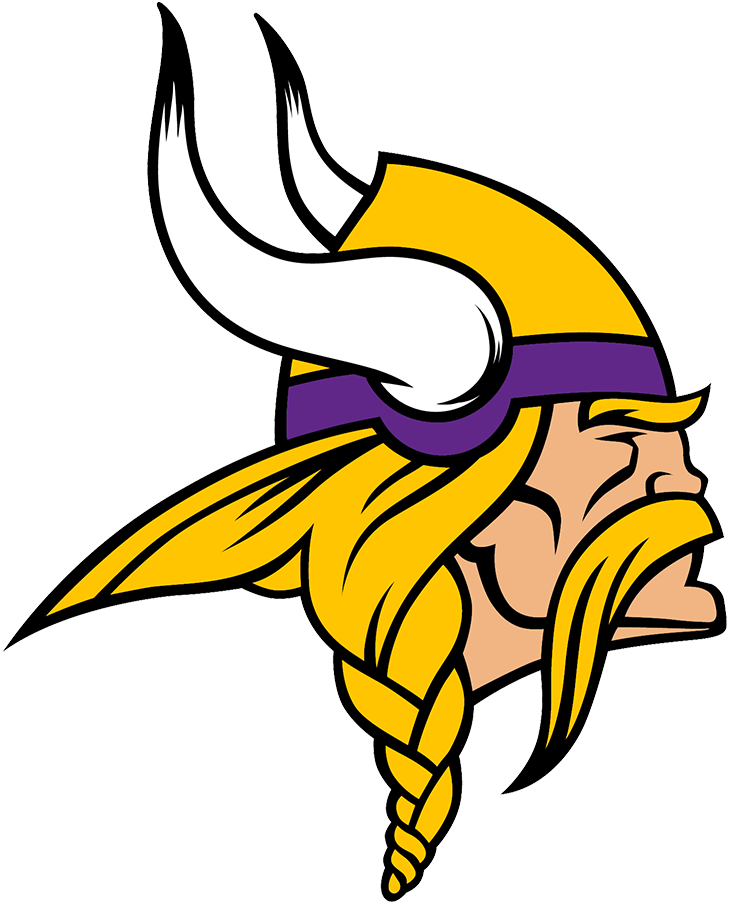
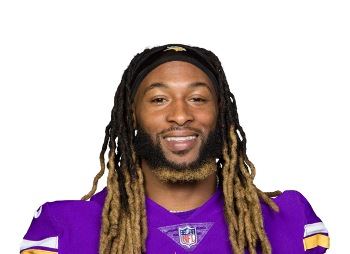

In [18]:
table = (
    GT(riser_faller_adp_comparison)
    .tab_header(
        title=gt.md("**Risers and Fallers**"),
        subtitle="Potential RB Risers and Fallers based on change in expected volume"
    )

    # center values for the following columns
    .cols_align(columns=["Team", "Rank", "RB", "Change"], align="center")

    # rename columns
    .cols_label(**{
        "Team": "",
        "Player Name": "",
        "Player": "Player",
        "Rank": "2024 Finish",
        "RB": "2025 ADP"
    })

    # add team logos
    .fmt_image(
        columns="Team",
        path="/content/drive/MyDrive/Substack/NFL images/Logos",
        file_pattern="{}.png"
    )

    # add player headshots
    .fmt_image(
        columns="Player Name",
        path="/content/drive/MyDrive/Substack/NFL images/RB",
        file_pattern="{}.png",
        height="60px",
        width="80px"
    )

    # add color gradient to "Change" column (red=faller, green=riser)
    .data_color(
        columns = "Change",
        domain=[-12, 6],  # range of values to be colored
        palette=["#9A1445", "#ECEFF1FF", "#149a6a"],
        na_color="white",
    )
    # .tab_style(style=style.text(color="green", weight="bold"),locations=loc.body(columns="RB", rows=[0,1]))
    # .tab_style(style=style.text(color="#d12e45", weight="bold"),locations=loc.body(columns="RB", rows=[2,3,4,5,6]))
)

table